In [23]:
import itertools
import os
import json
import copy
import sys
from collections import defaultdict
import itertools
import pandas as pd
from tqdm.notebook import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import linear_model
import seaborn as sns
import random
import seaborn as sns
import scipy.stats as stats
import pandas as pd
#import seaborn as sns
import seaborn as sns
from matplotlib import rcParams
import scipy
from scipy import stats
import seaborn as sns
from scipy import stats
import sys
import seaborn as sns
from utils import *
import numpy as np
pd.set_option('display.max_rows', 500)

In [24]:
AVAILBLE_DATASETS = ['DIALOG_pc.csv','DIALOG_tc.csv','FLICKR.csv','MLQE.csv','REAL_SUM.csv',
                     'SUM_EVAL.csv','TAC_08.csv','TAC_09.csv','TAC_11.csv']
data_path = 'final_df'
ds = 'TAC_11.csv'

# Analysis by Systems 

### Build Borda Count

In [25]:
considered_df_system = pd.read_csv(os.path.join(data_path,ds)).set_index(['System','Utterance'])
assert considered_df_system.shape[0] % considered_df_system.loc[0].shape[0] == 0
nbs_system = considered_df_system.shape[0] // considered_df_system.loc[0].shape[0] 
nbs_utt = considered_df_system.loc[0].shape[0] 

In [26]:
nbs_system,nbs_utt

(44, 54)

In [27]:
dic = {}

for column in list(considered_df_system.columns):
    print(column)
    dic['borda_{}'.format(column)] = []
    for i in range(nbs_system): 
        current_borda_count = np.argsort(np.argsort(considered_df_system.loc[i][column].values)).tolist()
        dic['borda_{}'.format(column)] += current_borda_count
dic['System'] = sum([['M{}'.format(i)]*nbs_utt for i in range(nbs_system)],[])
dic['Utt'] = sum([['U{}'.format(i) for i in range(nbs_utt)]* nbs_system],[])

H:pyr
H:resp
S3_pyr
S3_resp
ROUGE_WE_1
ROUGE_WE_2
JS_1
JS_2
ROUGE_L
ROUGE_1
ROUGE_2
BLEU
Chrfpp
BERTScore
MoverScore


In [28]:
df_borda_system = pd.DataFrame(dic).set_index('System')
df_borda_system.head()
human_metric = [ i for i in df_borda_system.columns if ('H:' in i and 'Utt' not in i)]
other_metric = [ i for i in df_borda_system.columns if ('H:' not in i and 'Utt' not in i)]
print("Human", human_metric)
print("Other", other_metric)

Human ['borda_H:pyr', 'borda_H:resp']
Other ['borda_S3_pyr', 'borda_S3_resp', 'borda_ROUGE_WE_1', 'borda_ROUGE_WE_2', 'borda_JS_1', 'borda_JS_2', 'borda_ROUGE_L', 'borda_ROUGE_1', 'borda_ROUGE_2', 'borda_BLEU', 'borda_Chrfpp', 'borda_BERTScore', 'borda_MoverScore']


In [29]:
df_borda_system

,borda_H:pyr,borda_H:resp,borda_S3_pyr,borda_S3_resp,borda_ROUGE_WE_1,borda_ROUGE_WE_2,borda_JS_1,borda_JS_2,borda_ROUGE_L,borda_ROUGE_1,borda_ROUGE_2,borda_BLEU,borda_Chrfpp,borda_BERTScore,borda_MoverScore,Utt
System,,,,,,,,,,,,,,,,
M0,48,53,51,52,51,51,51,50,53,51,53,53,48,51,51,U0
M0,53,52,53,53,53,53,53,51,51,53,52,52,53,53,53,U1
M0,52,51,52,51,52,52,52,48,52,52,51,50,52,52,52,U2
M0,51,50,50,50,50,50,50,49,50,50,50,51,35,50,50,U3
M0,41,49,16,16,16,11,23,14,6,19,12,10,21,31,37,U4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M43,20,2,8,9,8,8,8,8,13,7,13,11,8,11,8,U49
M43,24,21,22,18,21,37,18,18,18,19,23,21,38,34,36,U50
M43,39,22,20,22,18,18,17,29,29,21,34,34,24,25,27,U51


### Build training set

In [30]:
X_train = df_borda_system[other_metric].values
y_train = df_borda_system[human_metric].values

In [31]:
X_train.shape,y_train.shape,y_train[:,0].shape

((2376, 13), (2376, 2), (2376,))

In [32]:
assert len(X_train) == len(y_train)

In [64]:
res = {'coeff': [],"intercept": [],"alpha": []}
index_metric = 1
assert index_metric in range(0,len(human_metric))
for alpha in [0] +list(np.logspace(-5, 5, num=50)):
    print(alpha)
    if alpha == 0:
        clf = linear_model.LinearRegression(positive = True)
    else: 
        clf = linear_model.Lasso(alpha=alpha,positive = True)
    clf.fit(X_train,y_train[:,index_metric])
    res['coeff'].append(clf.coef_.tolist())
    res['alpha'].append(alpha/10)
    res['intercept'].append(clf.intercept_)

0
1e-05
1.5998587196060572e-05
2.559547922699533e-05
4.094915062380427e-05
6.55128556859551e-05
0.00010481131341546853
0.00016768329368110083
0.0002682695795279727
0.00042919342601287783
0.0006866488450042998
0.0010985411419875584
0.001757510624854793
0.002811768697974231
0.004498432668969444
0.0071968567300115215
0.011513953993264481
0.018420699693267165
0.029470517025518096
0.04714866363457394
0.07543120063354623
0.1206792640639329
0.19306977288832497
0.30888435964774846
0.49417133613238384
0.7906043210907702
1.2648552168552958
2.0235896477251556
3.2374575428176464
5.1794746792312125
8.286427728546842
13.257113655901108
21.209508879201927
33.9322177189533
54.286754393238596
86.85113737513521
138.9495494373139
222.29964825261956
355.64803062231283
568.9866029018305
910.2981779915227
1456.3484775012444
2329.951810515372
3727.593720314938
5963.623316594637
9540.954763499964
15264.179671752365
24420.53094548655
39069.399370546205
62505.51925273976
100000.0


Text(113.99999999999999, 0.5, 'Sparsity Coefficient')

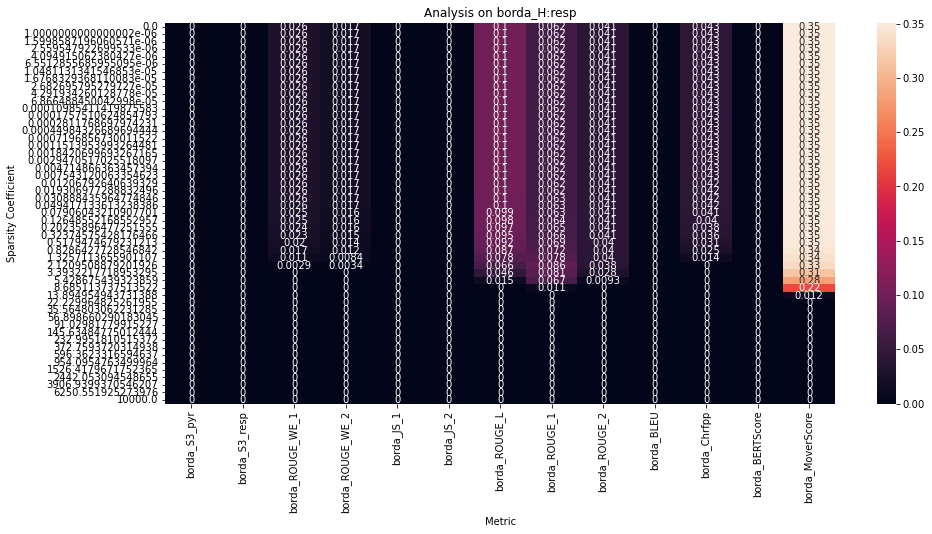

In [65]:
plt.figure(figsize=(15,7))
ax = sns.heatmap(np.array(res['coeff']), annot=True,yticklabels=res['alpha'],xticklabels=other_metric)

plt.title('Analysis on {}'.format(human_metric[index_metric]))
ax.set_xlabel('Metric')
ax.set_ylabel('Sparsity Coefficient')

ValueError: 'semi_log' is not a valid value for scale; supported values are 'linear', 'log', 'symlog', 'logit', 'function', 'functionlog'

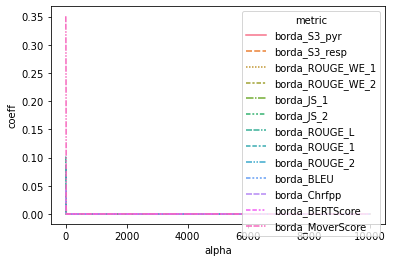

In [69]:
resulting_dic = {
    'metric':[],
    'alpha':[],
    'coeff':[]
}
for index,metric in enumerate(other_metric):
    for index_alpha,l in enumerate(res['coeff']):
        resulting_dic['coeff'].append(l[index])
        resulting_dic['metric'].append(metric)
        resulting_dic['alpha'].append(res['alpha'][index_alpha])
    
line_df = pd.DataFrame(resulting_dic)
sns.lineplot(data=line_df, x="alpha", y="coeff", hue="metric", style="metric")
plt.yscale('semi_log')

In [63]:
line_df

,metric,alpha,coeff
0,borda_S3_pyr,0.000000,0.000000
1,borda_S3_pyr,0.000001,0.000000
2,borda_S3_pyr,0.000001,0.000000
3,borda_S3_pyr,0.000002,0.000000
4,borda_S3_pyr,0.000003,0.000000
...,...,...,...
658,borda_MoverScore,2.682696,0.348604
659,borda_MoverScore,3.727594,0.347794
660,borda_MoverScore,5.179475,0.346668
661,borda_MoverScore,7.196857,0.345100


<AxesSubplot:xlabel='alpha', ylabel='coeff'>

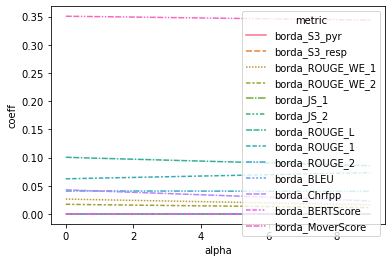

In [35]:
plt.figure(figsize=(15,7))
ax = sns.lineplot(np.array(res['coeff']), annot=True,yticklabels=res['alpha'],xticklabels=other_metric)

plt.title('Analysis on {}'.format(human_metric[index_metric]))
ax.set_xlabel('Metric')
ax.set_ylabel('Sparsity Coefficient')

/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: If using all scalar values, you must pass an index

<Figure size 1080x504 with 0 Axes>

# Analysis by utterance 

In [11]:
considered_df_utterance = pd.read_csv(os.path.join(data_path,ds)).set_index(['Utterance','System'])
assert considered_df_utterance.shape[0] % considered_df_utterance.loc['M0'].shape[0] == 0
nbs_utt = considered_df_utterance.shape[0] // considered_df_utterance.loc['M0'].shape[0] 
nbs_system = considered_df_utterance.loc['M0'].shape[0] 

In [12]:
nbs_system,nbs_utt

(44, 54)

In [20]:
pd.DataFrame(dic_utterance).head(100)

,borda_H:pyr,borda_H:resp,borda_S3_pyr,borda_S3_resp,borda_ROUGE_WE_1,borda_ROUGE_WE_2,borda_JS_1,borda_JS_2,borda_ROUGE_L,borda_ROUGE_1,borda_ROUGE_2,borda_BLEU,borda_Chrfpp,borda_BERTScore,borda_MoverScore
0,10,23,27,28,25,18,20,19,22,32,24,0,24,25,25
1,42,25,43,43,43,43,43,43,43,43,43,23,34,43,43
2,3,2,15,12,13,4,22,15,2,17,5,24,41,3,4
3,29,26,39,37,42,40,35,33,37,41,34,25,33,35,36
4,13,3,38,41,35,35,40,40,40,37,41,26,27,27,33
5,36,27,28,26,26,22,26,22,25,30,18,27,39,14,22
6,28,28,8,14,14,16,1,14,23,11,28,28,3,2,0
7,9,4,34,34,38,39,38,35,28,35,32,29,38,32,29
8,17,29,17,16,20,24,18,17,7,15,20,30,0,6,8
9,22,30,23,21,27,25,25,21,24,22,16,31,10,34,31


In [16]:
dic_utterance = {}

for column in list(considered_df_utterance.columns):
    print(column)
    dic_utterance['borda_{}'.format(column)] = []
    for i in range(nbs_utt): 
        current_borda_count = np.argsort(np.argsort(
            considered_df_utterance.loc['M{}'.format(i)][column].values)).tolist()
        dic_utterance['borda_{}'.format(column)] += current_borda_count

H:pyr
H:resp
S3_pyr
S3_resp
ROUGE_WE_1
ROUGE_WE_2
JS_1
JS_2
ROUGE_L
ROUGE_1
ROUGE_2
BLEU
Chrfpp
BERTScore
MoverScore


In [22]:
dic_utterance['System'] = sum([['M{}'.format(i) for i in range(nbs_system)]*nbs_utt],[]) # TODO : pas sur
dic_utterance['Utt'] = sum([['U{}'.format(i)]* nbs_utt  for i in range(nbs_system)],[])
df_borda_utterance = pd.DataFrame(dic_utterance).set_index('Utt')

In [23]:
human_metric = [ i for i in df_borda_utterance.columns if ('H:' in i and 'System' not in i)]
other_metric = [ i for i in df_borda_utterance.columns if ('H:' not in i and 'System' not in i)]
print("Human", human_metric)
print("Other", other_metric)

Human ['borda_H:pyr', 'borda_H:resp']
Other ['borda_S3_pyr', 'borda_S3_resp', 'borda_ROUGE_WE_1', 'borda_ROUGE_WE_2', 'borda_JS_1', 'borda_JS_2', 'borda_ROUGE_L', 'borda_ROUGE_1', 'borda_ROUGE_2', 'borda_BLEU', 'borda_Chrfpp', 'borda_BERTScore', 'borda_MoverScore']


### Building Training set

In [24]:
X_train_utterance = df_borda_utterance[other_metric].values
y_train_utterance = df_borda_utterance[human_metric].values

In [27]:
X_train_utterance.shape,y_train_utterance.shape,y_train_utterance[:,0].shape

((2376, 13), (2376, 2), (2376,))

In [28]:
res_utterance = {'coeff': [],"intercept": [],"alpha": []}
index_metric = 1
assert index_metric in range(0,len(human_metric))
for alpha in range(0,100,10):
    if alpha == 0:
        clf = linear_model.LinearRegression(positive = True)
    else: 
        clf = linear_model.Lasso(alpha=alpha/10,positive = True)
    clf.fit(X_train_utterance,y_train_utterance[:,index_metric])
    res_utterance['coeff'].append(clf.coef_.tolist())
    res_utterance['alpha'].append(alpha/10)
    res_utterance['intercept'].append(clf.intercept_)

Text(114.0, 0.5, 'Sparsity Coefficient')

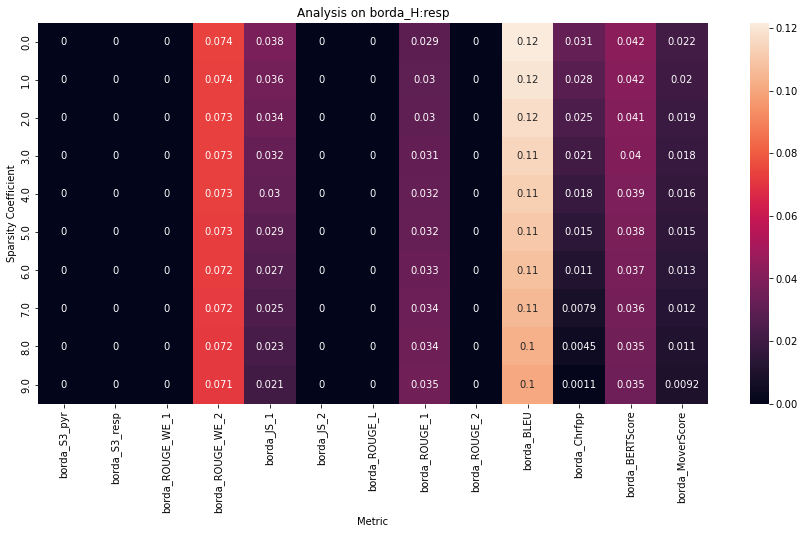

In [29]:
plt.figure(figsize=(15,7))
ax = sns.heatmap(np.array(res_utterance['coeff']), 
                 annot=True,yticklabels=res_utterance['alpha'],xticklabels=other_metric)

plt.title('Analysis on {}'.format(human_metric[index_metric]))
ax.set_xlabel('Metric')
ax.set_ylabel('Sparsity Coefficient')